<a href="https://colab.research.google.com/github/santoshrsarangi/tensorflow/blob/main/computer-vision/4_Pretrained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
from google.colab import files
r=files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:24<00:00, 27.4MB/s]
100% 812M/812M [00:24<00:00, 35.0MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

In [7]:
import os, pathlib, shutil

In [8]:
src_dir = pathlib.Path("train")
dst_dir = pathlib.Path("cats-vs-dogs")

In [9]:
def create_directory(name, start_index, end_index):

  for category in ["cat", "dog"]:

    sub_dir = dst_dir / name/ category
    os.makedirs(sub_dir)

    for i in range(start_index, end_index):
      src_file = src_dir / f"{category}.{i}.jpg"
      shutil.copy(src=src_file, dst=sub_dir)

In [10]:
create_directory("train", 0, 1000)
create_directory("validation", 1000, 1500)
create_directory("test", 1500, 2500)

In [11]:
train_dataset = image_dataset_from_directory(dst_dir / "train", image_size = (180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory(dst_dir / "validation", image_size = (180, 180), batch_size=32)
test_dataset = image_dataset_from_directory(dst_dir / "test", image_size = (180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(180, 180, 3))
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [13]:
base_model_with_top_layer = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
base_model_with_top_layer.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

1) Extract base model (VGG16) features and labels and add classification layers to train and validate. 

In [14]:
import numpy as np

def get_features_and_labels(dataset):

  allfeatures = []
  alllabels = []

  for images, labels in dataset:

    processed_image = keras.applications.vgg16.preprocess_input(images)

    features = base_model.predict(processed_image)

    allfeatures.append(features)
    alllabels.append(labels)

  return np.concatenate(allfeatures), np.concatenate(alllabels)

In [15]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [16]:
train_features.shape

(2000, 5, 5, 512)

In [18]:
input = keras.Input(shape=(5,5,512))

x = layers.Flatten()(input)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(input, output)

In [19]:
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=['accuracy'])

In [20]:
mycallback = [
    keras.callbacks.ModelCheckpoint(
        filepath = "feature_extraction.keras",
        save_best_only=True,
        monitor='val_loss'
    )
]

In [22]:
history = model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=mycallback)

Epoch 1/20
63/63 [==============================] - 3s 11ms/step - loss: 15.7053 - accuracy: 0.9205 - val_loss: 21.4009 - val_accuracy: 0.9060
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 2.2429 - accuracy: 0.9835 - val_loss: 3.5805 - val_accuracy: 0.9750
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2.7301 - accuracy: 0.9840 - val_loss: 2.7508 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2.4820 - accuracy: 0.9880 - val_loss: 4.7178 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.4664 - accuracy: 0.9885 - val_loss: 5.8463 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 0s 8ms/step - loss: 0.3120 - accuracy: 0.9980 - val_loss: 6.6800 - val_accuracy: 0.9660
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6962 - accuracy: 0.9935 - val_loss: 4.3645 - val_accuracy: 0.9730
Epoch 8/20
63/63 

Plot the result

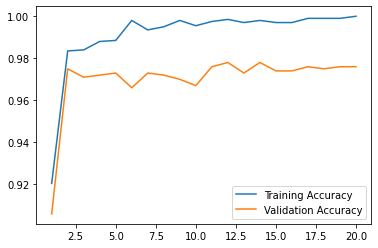

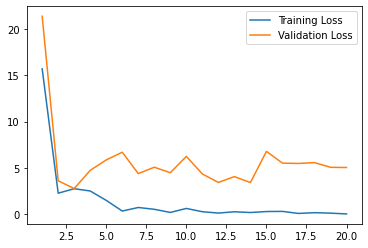

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, 21)

plt.plot(epochs, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, history.history['loss'], label="Training Loss")
plt.plot(epochs, history.history['val_loss'], label="Validation Loss")
plt.legend()

plt.show()

In [25]:
#Feature extraction, Data Augumentation and training....

In [28]:
new_model_base = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)

len(new_model_base.trainable_weights)

26

In [29]:
new_model_base.trainable = False

In [30]:
len(new_model_base.trainable_weights)

0

In [32]:
data_augumentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])